# Handling Missing Data

- The difference between data found in many tutorials and data in the real world is that **real-world data is rarely clean and homogeneous**.
- In this chapter, we will discuss:
> - Some **general considerations** for missing data,
> - How Pandas chooses to **represent it**,
> - Some **built-in Pandas tools** for handling missing data in Python.

In [1]:
import pandas as pd

In [2]:
df = pd.DataFrame(["1", "2", None, "4"])
df

,0
0,1
1,2
2,None
3,4


In [3]:
df.dtypes

0    object
dtype: object

- ## Trade-offs in Missing Data Conventions

- A number of approaches have been developed to **track the presence of missing data** in a table or `DataFrame`:
- 
> - Using a **mask** that globally indicates missing values:
>> - The mask might be an entirely **separate Boolean array**, or it might involve **appropriation of one bit in the data representation** to locally indicate the null status of a value.
>> - 
> - Choosing a **sentinel value** that indicates a missing entry:
>> - The sentinel value could be some **data-specific convention**, such as indicating a missing integer value with `–9999` or some rare bit pattern, or it could be a **more global convention**, such as indicating a missing floating-point value with `NaN` (Not a Number), a special value that is part of the IEEE floating-point specification.
>> - 
- **Neither of these approaches is without trade-offs:**
> - Use of a separate mask array requires **allocation of an additional Boolean array, which adds overhead** in both storage and computation,
> - A sentinel value **reduces the range of valid values that can be represented**, and may **require extra (often non-optimized) logic in CPU and GPU arithmetic** because common special values like NaN are not available for all data
types.

- Different languages and systems use different conventions.

## Missing Data in Pandas

- The way in which Pandas handles missing values is **constrained by its reliance on the NumPy package**, which does not have a **built-in notion of NA values for non-floating-point data types**.
- Pandas has **two "modes" of storing and manipulating null values**:
> - The **default** mode is to use a **sentinel-based missing data scheme**, with sentinel values `NaN` or `None` depending on the type of the data.
> - Alternatively, you can opt in to using the **nullable data types (dtypes) Pandas provides**, which results in the creation an accompanying **mask array** to track missing entries whichare presented to the user as the special `pd.NA` value.

- To develop some intuition into **why these choices are made**, let's dive quickly into the **trade-offs** inherent in `None`, `NaN`, and `NA`.

- As usual, we'll start by **importing NumPy and Pandas**:

In [4]:
import numpy as np
import pandas as pd

### None as a Sentinel Value

- For some data types, Pandas uses **`None` as a sentinel value**.
- `None` is a **Python object**, which means that any array containing `None` must have **`dtype=object`**—that is, it must be a sequence of Python objects.

- For example, observe what happens if you pass None to a NumPy array:

In [5]:
vals1 = np.array([1, None, 2, 3])
vals1

array([1, None, 2, 3], dtype=object)

- This `dtype=object` means that the **best common type representation NumPy could infer** for the contents of the array is that they are **Python objects**.

- The **downside** of using `None` in this way is that **operations on the data will be done at the Python level**, with much more overhead than the typically fast operations seen for arrays with native types:

In [6]:
%%time
np.arange(1E6, dtype=int).sum()

CPU times: total: 15.6 ms
Wall time: 8 ms


1783293664

In [7]:
%%time
np.arange(1E6, dtype=object).sum()

CPU times: total: 312 ms
Wall time: 376 ms


499999500000

- Further, because **Python does not support arithmetic operations with `None`**, aggregations like `sum` or `min` will generally lead to an **error**:

In [8]:
try:
    vals1.sum()
except TypeError as e:
    print(e)

unsupported operand type(s) for +: 'int' and 'NoneType'


- For this reason, **Pandas does not use `None` as a sentinel in its numerical arrays**.

### NaN - Missing Numerical Data

- The other missing data sentinel, `NaN` is different; it is a **special floating-point value recognized by all systems that use the standard IEEE floating-point representation**:

In [9]:
vals2 = np.array([1, np.nan, 3, 4]) 
vals2

array([ 1., nan,  3.,  4.])

- Notice that NumPy chose a native **floating-point type** for this array, this means that **unlike the object array from before, this array supports fast operations** pushed into compiled code.

- Keep in mind that `NaN` is a bit like a **data virus**—it infects any other object it touches, **regardless of the operation, the result of arithmetic with `NaN` will be another `NaN`**:

In [10]:
1 + np.nan

nan

In [11]:
0 * np.nan

nan

- This means that aggregates over the values don't result in an error, but **not always useful**:

In [12]:
vals2.sum(), vals2.min(), vals2.max()

(nan, nan, nan)

- That said, **NumPy does provide ``NaN``-aware versions of aggregations** that will ignore these missing values:

In [13]:
np.nansum(vals2), np.nanmin(vals2), np.nanmax(vals2)

(8.0, 1.0, 4.0)

- The main **downside** of `NaN` is that it is specifically a floating-point value; **there is no equivalent `NaN` value for integers, strings, or other types**.

### NaN and None in Pandas

- `NaN` and `None` both have their place, and **Pandas is built to handle the two of them nearly interchangeably**, converting between them where appropriate:

In [14]:
pd.Series([1, np.nan, 2, None])

0    1.0
1    NaN
2    2.0
3    NaN
dtype: float64

- For types that don't have an available sentinel value, **Pandas automatically typecasts when NA values are present**.

- For example, if we set a value in an **integer** array to ``np.nan``, it will automatically be upcast to a **floating-point** type to accommodate the NA:

In [15]:
x = pd.Series(range(2), dtype=int)
x

0    0
1    1
dtype: int32

In [16]:
x[0] = None
x

0    NaN
1    1.0
dtype: float64

- Notice that in addition to casting the integer array to floating point, **Pandas automatically converts the ``None`` to a ``NaN`` value**.

- The following table lists the **upcasting conventions in Pandas** when NA values are introduced:

|Typeclass     | Conversion when storing NAs | NA sentinel value      |
|--------------|-----------------------------|------------------------|
| ``floating`` | No change                   | ``np.nan``             |
| ``object``   | No change                   | ``None`` or ``np.nan`` |
| ``integer``  | Cast to ``float64``         | ``np.nan``             |
| ``boolean``  | Cast to ``object``          | ``None`` or ``np.nan`` |


- Keep in mind that **in Pandas, string data is always stored with an ``object`` dtype**.

## Pandas Nullable Dtypes

- In **early versions of Pandas**, `NaN` and `None` as sentinel values were the only missing data representations available.
- The **primary difficulty** this introduced was with regard to the **implicit type casting**: for example, there was no way to represent a true integer array with missing data.
- To address this difficulty, **Pandas later added nullable dtypes**, which are distinguished from regular dtypes by **capitalization of their names** (e.g., `pd.Int32` versus `np.int32`).
- For backward compatibility, **these nullable dtypes are only used if specifically requested**.

- For example, here is a **`Series` of integers with missing data**, created from a list containing all three available markers of missing data:

In [17]:
pd.Series([1, np.nan, 2, None, pd.NA], dtype='Int32')

0       1
1    <NA>
2       2
3    <NA>
4    <NA>
dtype: Int32

In [18]:
pd.Series([1, np.nan, 2, None, pd.NA]).convert_dtypes()

0       1
1    <NA>
2       2
3    <NA>
4    <NA>
dtype: Int64

## Operating on Null Values

- As we have seen, **Pandas treats `None`, `NaN`, and `NA` as essentially interchangeable** for indicating missing or null values.
- To facilitate this convention, Pandas provides several methods for **detecting**, **removing**, and **replacing** null values in Pandas data structures:

> - ``isnull``: Generates a Boolean mask indicating missing values
> - ``notnull``: Opposite of ``isnull``
> - ``dropna``: Returns a filtered version of the data
> - ``fillna``: Returns a copy of the data with missing values filled or imputed

### Detecting Null Values

- Pandas data structures have **two useful methods for detecting null data**: `isnull` and `notnull`.

- Eeither one will **return a Boolean mask** over the data, for example:

In [19]:
data = pd.Series([1, np.nan, 'hello', None])

In [20]:
data.isnull()

0    False
1     True
2    False
3     True
dtype: bool

- Boolean masks **can be used directly as a `Series` or `DataFrame` index**:

In [21]:
data[data.notnull()]

0        1
2    hello
dtype: object

- The `isnull()` and `notnull()` methods produce **similar Boolean results for ``DataFrame`` objects**.

### Dropping Null Values

- In addition to these masking methods, there are the **convenience method `dropna` (which removes NA values)**.

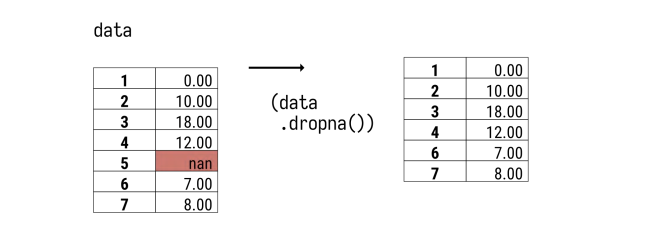

- For a `Series`, the result is straightforward:

In [22]:
data.dropna()

0        1
2    hello
dtype: object

- For a ``DataFrame``, there are more options, consider the following ``DataFrame``:

In [23]:
df = pd.DataFrame([[1, np.nan, 2],
                   [2, 3, 5],
                   [np.nan, 4, 6]])
df

,0,1,2
0,1.0,NaN,2
1,2.0,3.0,5
2,NaN,4.0,6


- We cannot drop single values from a `DataFrame`; **we can only drop entire rows or columns**.
- Depending on the application, you might want one or the other, so **`dropna` includes a number of options for a `DataFrame`**.

- By default, `dropna` will **drop all rows in which any null value is present**:

In [24]:
df.dropna()

,0,1,2
1,2.0,3.0,5


- Alternatively, you can drop NA values **along a different axis**, using `axis=1` or `axis='columns'` drops all columns containing a null value:

In [25]:
df.dropna(axis='columns')

,2
0,2
1,5
2,6


- You might rather be interested in **dropping rows or columns with all NA values, or a majority of NA values**.
- This can be specified through the `how` or `thresh` parameters, which **allow fine control of the number of nulls to allow through**:
> - The default is `how='any'`, such that **any row or column containing a null value will be dropped**,
> - You can also specify `how='all'`, which will **only drop rows/columns that contain all null values**,
> - For finer-grained control, the `thresh` parameter lets you **specify a minimum number of non-null values for the row/column to be kept**.

- Consider the following example:

In [26]:
df[3] = np.nan
df

,0,1,2,3
0,1.0,NaN,2,NaN
1,2.0,3.0,5,NaN
2,NaN,4.0,6,NaN


In [27]:
df.dropna(axis='columns', how='all')

,0,1,2
0,1.0,NaN,2
1,2.0,3.0,5
2,NaN,4.0,6


In [28]:
df.dropna(axis='rows', thresh=3)

,0,1,2,3
1,2.0,3.0,5,NaN


### Filling Null Values

- Sometimes rather than dropping NA values, you'd like to **replace them with a valid value**.
- This value might be a **single number** like zero, or it might be **some sort of imputation or interpolation** from the good values.
- Pandas provides the **`fillna` method**, which **returns a copy of the array with the null values replaced**.
- Pandas also provides the **`ffill` and `bfill` methods**, they **return a copy of the array with the null values replaced forward or backward respectively**.

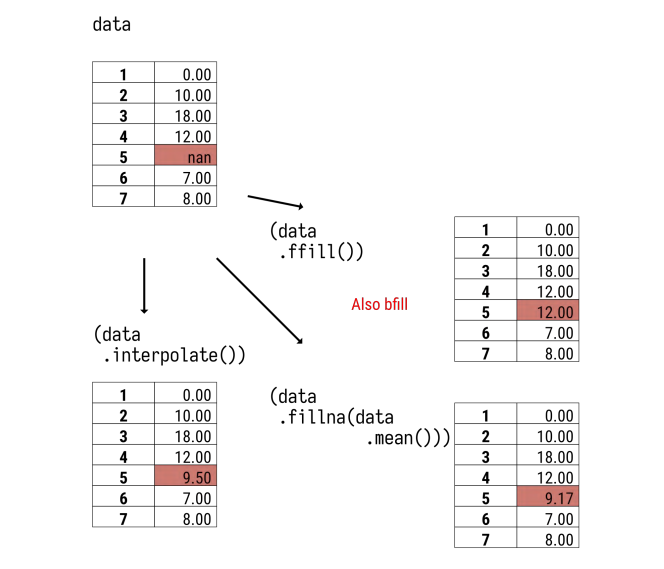

- Consider the following `Series`:

In [29]:
data = pd.Series([1, np.nan, 2, None, 3], index=list('abcde'), dtype='Int32')
data

a       1
b    <NA>
c       2
d    <NA>
e       3
dtype: Int32

- We can **fill NA entries with a single value**, such as zero:

In [30]:
data.fillna(0)

a    1
b    0
c    2
d    0
e    3
dtype: Int32

- We can **specify a forward or a backward fill** to propagate the **previous value forward** or the **next data value backward** respectively:

In [31]:
data.ffill()

a    1
b    1
c    2
d    2
e    3
dtype: Int32

In [32]:
data.bfill()

a    1
b    2
c    2
d    3
e    3
dtype: Int32

- In the case of a `DataFrame`, the options are similar, but we can also **specify an `axis` along which the fills should take place**:

In [33]:
df

,0,1,2,3
0,1.0,NaN,2,NaN
1,2.0,3.0,5,NaN
2,NaN,4.0,6,NaN


In [34]:
df.ffill(axis=1)

,0,1,2,3
0,1.0,1.0,2.0,2.0
1,2.0,3.0,5.0,5.0
2,NaN,4.0,6.0,6.0


- Notice that **if a previous value is not available during a forward fill, the NA value remains**.

### Interpolating Data

- Another option for replacing missing data is the **`interpolate` method**.
- This comes in handy **if the data is ordered (as time series data often is) and there are holes in the data**.

- For example if you had temperature measurements, temp, you could fill in the values using this:

In [35]:
temp = pd. Series ([32 , 40, None , 42, 39, 32])
temp

0    32.0
1    40.0
2     NaN
3    42.0
4    39.0
5    32.0
dtype: float64

In [36]:
temp . interpolate ()

0    32.0
1    40.0
2    41.0
3    42.0
4    39.0
5    32.0
dtype: float64

- Notice that **the value for index label 2 was missing**, however, there are values for index labels 1 and 3.
- After interpolation, **the missing value becomes 41.0**, the interpolation of the values around the missing value.